In [3]:
# increase default window size for notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_15924\696421802.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import timeit
from datetime import timedelta
from dataclasses import dataclass       # C like structure
import glob                             # finds all the pathnames matching specified pattern
import datetime as dt
import random
!python --version
print('pandas version: ' + pd.__version__)
print('numpy version: ' + np.__version__)

Python 3.9.7
pandas version: 1.4.2
numpy version: 1.21.5


In [4]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants

imported custom_plot.py
data_clean imported
data_preprocess imported


In [5]:
%matplotlib notebook
# Plot related packages,%matplotlib notebook makes plots in jupyter interactive
# constants for plotting
x_label_elapsedtime = 0
x_label_datetime = 1

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
import seaborn as sns

### Load processed time series static-dynamic-static cycle samples with cell IDs
It is a list of valid charge/discharge/dynamic cycles with static voltage in the beginning and end

In [7]:
# Load processed data drive cycles
import pickle
    
# load last saved df from phase1 data and convert time stamp and sort
dir_path = os.path.join(cwd, 'csv')
src_path = os.path.join(dir_path, 'li_drive_cycles.pkl')

with open(src_path, 'rb') as f:
    li_drive_cycles = pickle.load(f)


In [8]:
def save_object(obj, path, filename):
    import pickle
    src = os.path.join(path, filename)
    with open(src, 'wb') as outp:
        pickle.dump(obj, outp, protocol=pickle.HIGHEST_PROTOCOL)

def load_object(path, filename):
    import pickle
    src = os.path.join(path, filename)
    with open(src, 'rb') as f:
        obj = pickle.load(f)
        return obj

### Important notice: never use same loss and metrics function for a model, otherwise it will not compile.
The loss function is used to optimize your model. This is the function that will get minimized by the optimizer.
A metric is used to judge the performance of your model. This is only for you to look at and has nothing to do with the optimization process.


In [9]:
import math

class TimeSeries:
    def __init__(self, id: str, type: str, df: object, splits: int):
        self.id = id             # anything, index in the array
        self.type = type         # charge/discharge/mixed cycle
        self.df = df             # time series pandas dataframe (the actual cycle)
        self.num_splits = splits      # divide df into 4 equal splits
        self.li_horizontal_divided_ts_obj = self.get_horizontally_divided_datasets()       # each element of this list is an object that will contain all results of ts analysis
        self.li_horizontal_inc_ts_obj = self.get_horizontally_inc_datasets()

    # num_splits: how many equal splits to make from the original df
    def get_horizontally_divided_datasets(self):
        df_temp = self.df.copy()
        li_div = np.array_split(df_temp, self.num_splits)
        li_ts_obj = []
        for i,df in enumerate(li_div):
            split_df = df.copy()
            li_ts_obj.append(TimeSeriesResults(str(self.id) + '_' + str(i), split_df))
        return li_ts_obj

    def get_horizontally_inc_datasets(self):
        li_inc = []
        div = 1 / self.num_splits
        total_rows = len(self.df)
        for i in range(1, self.num_splits+1):
            li_inc.append(self.df.copy().iloc[:math.floor(total_rows * div * i)])

        li_ts_obj = []
        for i,df in enumerate(li_inc):
            split_df = df.copy()
            li_ts_obj.append(TimeSeriesResults(str(self.id) + '_' + str(i), split_df))
        return li_ts_obj

class TimeSeriesResults:
    def __init__(self, id: str, df: object):          # init variables
        self.id = id
        self.df = df
        self.history = ""
        self.model_name = "model.h5"
        self.mse = -1000
        self.rmse = -1000
        self.mae = -1000
        self.ts_analysis = ""  # contains TimeSeriesAnalysis object for this result

    def plot_loss(self):
        history = self.history
        import matplotlib
        font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 10}
        matplotlib.rc('font', **font)
        fig = plt.figure(figsize =(12 ,5))
        
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model loss vs #Epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

class TimeSeriesAnalysis:
    def __init__(self, df: object, seq_window_size: int, save_path: str='', normalize: bool=False, batch_size=1, stacked=False):
        self.df = df[['V', 'current', 'Temp']]   # only necessary columns
        self.seq_window_size = seq_window_size
        self.train, self.val, self.test = np.split(self.df, [int(.6*len(df)), int(.8*len(df))])  # train-val-test: 60%,20%,20%
        self.train_X, self.train_y = self.df_to_supervised_multivariate(self.train.to_numpy(), seq_window_size, 0)
        self.val_X, self.val_y = self.df_to_supervised_multivariate(self.val.to_numpy(), seq_window_size, 0)
        self.test_X, self.test_y = self.df_to_supervised_multivariate(self.test.to_numpy(), seq_window_size, 0)
        self.batch_normalization = normalize
        self.path = save_path
        self.batch_size = batch_size
        self.stacked = stacked

    # [temporal input sequence] [output]
    # [[[1], [2], [3], [4], [5]]] [6]
    # [[[2], [3], [4], [5], [6]]] [7]
    # [[[3], [4], [5], [6], [7]]] [8]

    def df_to_supervised_multivariate(self, df_as_np, input_window, label_index, output_window=1):
        X = []
        y = []
        for i in range(len(df_as_np) - input_window):
            X.append(df_as_np[i:i+input_window, 0:df_as_np.shape[1]])
            label = df_as_np[i+input_window][label_index]    # index of output label ie voltage
            y.append(label)
        return np.array(X), np.array(y)

    def lstm_model(self, path, train_X, train_y, val_X, val_y, window_size, num_neurons=32, dropout=0):
        all_history = pd.DataFrame()

        batch_size = self.batch_size
        # create and fit the LSTM network
        if self.stacked:     # stacked LSTM
            model = Sequential()
            model.add(LSTM(32, batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), stateful=True, return_sequences=True))
            model.add(LSTM(32, batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), stateful=True))
            model.add(Dense(8, 'relu'))
            model.add(Dense(1))
        else:
            model = Sequential()
            model.add(LSTM(num_neurons, batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), stateful=True))   # batch_input_shape=batch_size, timesteps, features
            model.add(Dense(8, 'relu'))
            model.add(Dense(1, 'linear'))
        
        model.summary()
        # save_best_only=true saves the best model with lowest validation loss
        model_path = os.path.join(path, 'model.h5')        
        my_callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,verbose=0,mode='min'),  # minimize validation loss
            tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True)
        ]

        model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00001), metrics=[MeanAbsoluteError()])

        # measuers performance on every epoch on the validation dataset
        # calls back checkpoint after every epoch and saves model if validation loss is lower than before
        # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

        for i in range(100):
            history = model.fit(train_X, train_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(val_X, val_y), callbacks=my_callbacks)
            this_history = pd.DataFrame(history.history)
            all_history = pd.concat([all_history, this_history])
            model.reset_states()

        dict_history = all_history.to_dict('list')
        return model_path, dict_history

2442
                 timestamp  current  min_SOC  cur_integral_module1  \
121313 2022-02-23 22:06:42      0.0    94.80                   0.0   
121314 2022-02-23 22:06:43      0.0    94.80                   0.0   
121315 2022-02-23 22:06:44      0.0    94.80                   0.0   
121316 2022-02-23 22:06:45      0.0    94.80                   0.0   
121317 2022-02-23 22:06:46      0.0    94.80                   0.0   
...                    ...      ...      ...                   ...   
122529 2022-02-23 22:26:58     -9.4    88.77              -20300.0   
122530 2022-02-23 22:26:59     14.0    88.77              -20200.0   
122531 2022-02-23 22:27:00    -10.9    88.78              -20200.0   
122532 2022-02-23 22:27:01    -43.0    88.77              -20300.0   
122533 2022-02-23 22:27:02    -42.5    88.76              -20300.0   

        contactor_state  contactor_off_time       V  Temp  elapsed_sec  
121313              0.0              1847.0  4.0742  13.0          0.0  
121314  

<IPython.core.display.Javascript object>


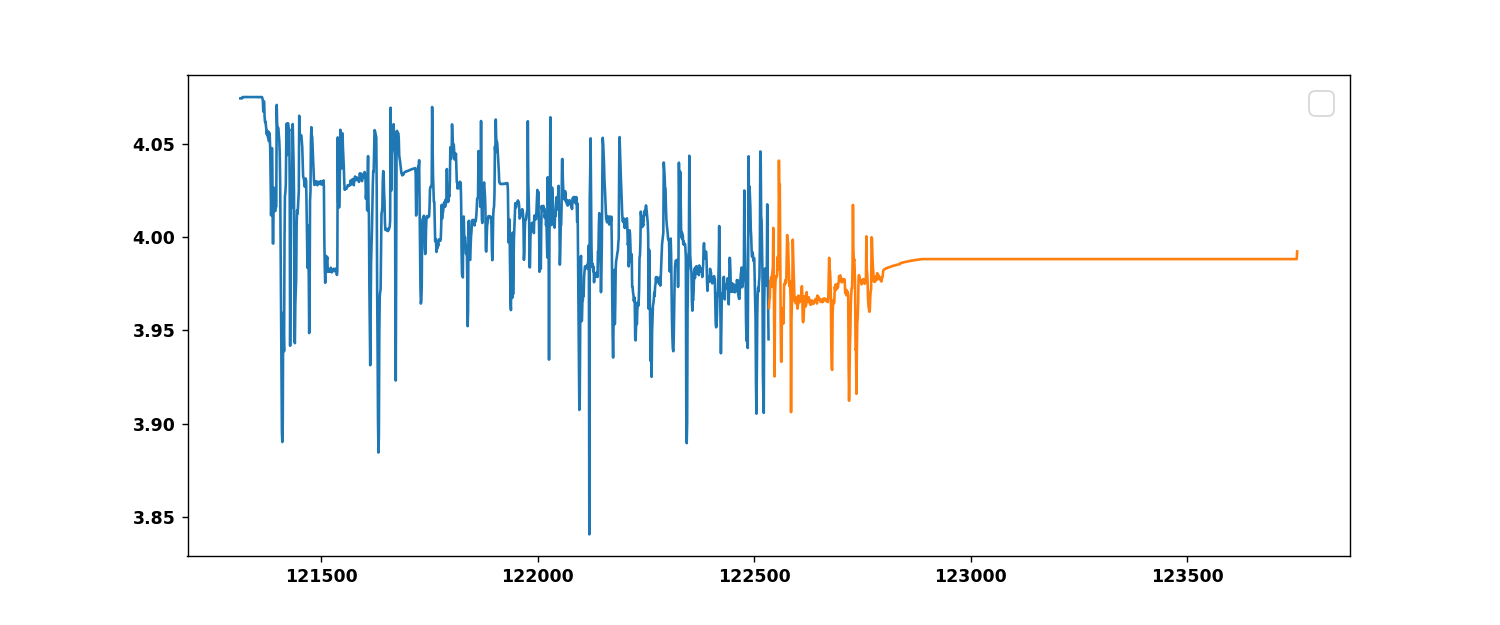

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'df_temp2' is not defined

In [11]:
%matplotlib notebook
import matplotlib
# test
print(len(li_drive_cycles[3]))
ts = TimeSeries(5, "discharge", li_drive_cycles[3], 2)
# print(len(ts.li_horizontal_divided_ts_obj[2].df))
print(ts.li_horizontal_divided_ts_obj[0].df)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)
fig = plt.figure(figsize =(12 ,5))
plt.legend(bbox_to_anchor=(1.0, 1.0),prop={'size': 18,'weight' :'normal'})


df_temp0 = ts.li_horizontal_divided_ts_obj[0].df
df_temp1 = ts.li_horizontal_divided_ts_obj[1].df
# df_temp2 = ts.li_horizontal_divided_ts_obj[2].df

# # # print(df_temp)
df_temp0['V'].plot()
df_temp1['V'].plot()
df_temp2['V'].plot(linestyle = 'dashed')


<IPython.core.display.Javascript object>


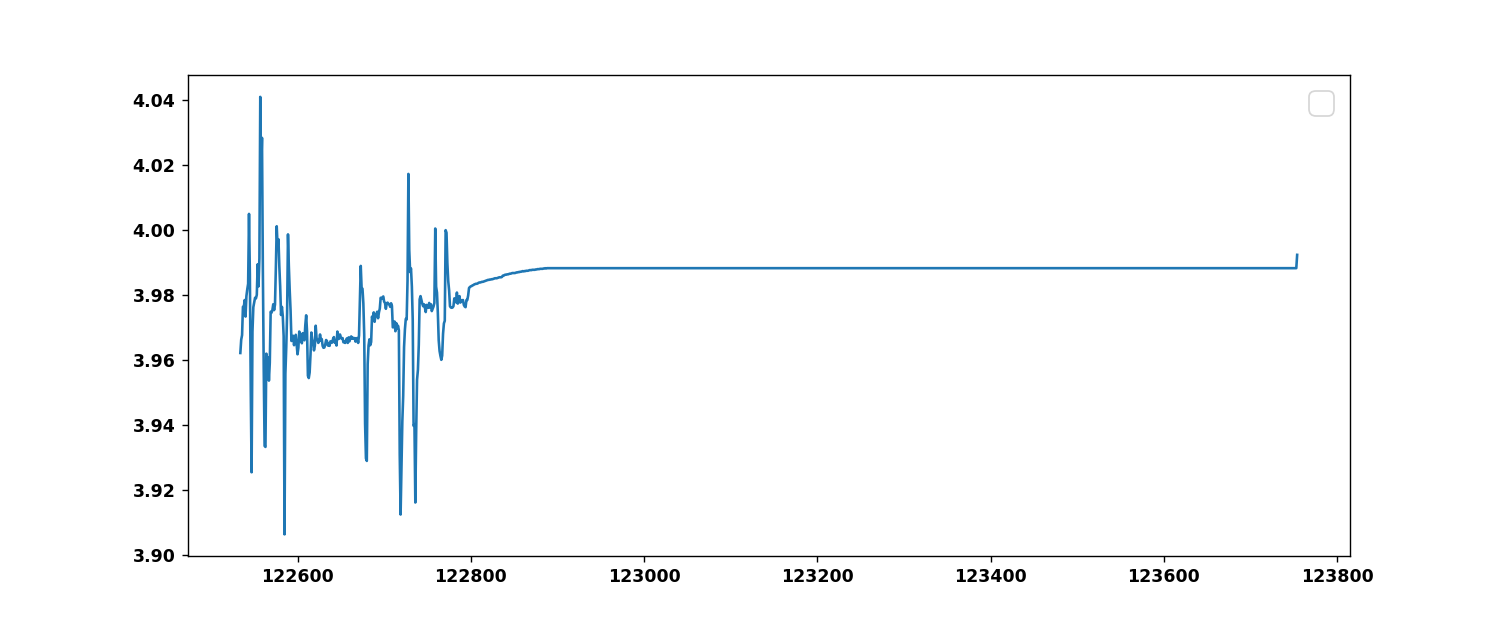

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                     current  min_SOC  cur_integral_module1  contactor_state  \
timestamp                                                                      
2022-02-23 22:06:42      0.0    94.80                   0.0              0.0   
2022-02-23 22:06:43      0.0    94.80                   0.0              0.0   
2022-02-23 22:06:44      0.0    94.80                   0.0              0.0   
2022-02-23 22:06:45      0.0    94.80                   0.0              0.0   
2022-02-23 22:06:46      0.0    94.80                   0.0              0.0   
...                      ...      ...                   ...              ...   
2022-02-23 22:47:19      0.0    87.69              -23900.0              0.0   
2022-02-23 22:47:20      0.0    87.69              -23900.0              0.0   
2022-02-23 22:47:21      0.0    87.69              -23900.0              0.0   
2022-02-23 22:47:22      0.0    87.69              -23900.0              0.0   
2022-02-23 22:47:23      0.0    87.70   

<AxesSubplot:>

In [12]:
%matplotlib notebook
import matplotlib
# Sample draw
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)
fig = plt.figure(figsize =(12 ,5))
plt.legend(bbox_to_anchor=(1.0, 1.0),prop={'size': 18,'weight' :'normal'})

ts = TimeSeries(5, "discharge", li_drive_cycles[3], 1)
df_temp = ts.li_horizontal_divided_ts_obj[0].df.copy()
df_temp = df_temp.set_index('timestamp')
print(df_temp)

df_temp1['V'].plot()

In [13]:
# hyperparams
SEQUENCE_WINDOW_SIZE = 5    # look back time steps
BATCH_SIZE = 1
NUM_SPLITS_EACH_TS = 3

# append all drive cycles in a list
li_ts = []
for i, df in enumerate(li_drive_cycles):
    li_ts.append(TimeSeries(i, "discharge", df.copy(), NUM_SPLITS_EACH_TS))
    


In [18]:
# Print train data
for i in range(len(li_ts)):
    for j in range(len(li_ts[i].li_horizontal_divided_ts_obj)):            # for each split of the cycle
        tsx_an = TimeSeriesAnalysis(li_ts[i].li_horizontal_divided_ts_obj[j].df, SEQUENCE_WINDOW_SIZE, dir_path, False, BATCH_SIZE, False)
        li_ts[i].li_horizontal_divided_ts_obj[j].ts_analysis = tsx_an
        print(li_ts[i].li_horizontal_divided_ts_obj[j].ts_analysis.train_X)
        print(li_ts[i].li_horizontal_divided_ts_obj[j].ts_analysis.train_y)
#         tsx_an.
        break
    break

[[[  4.1432   0.      14.25  ]
  [  4.1432   0.      14.25  ]
  [  4.1432   0.      14.25  ]
  [  4.1432   0.      14.25  ]
  [  4.1432   0.      14.25  ]]

 [[  4.1432   0.      14.25  ]
  [  4.1432   0.      14.25  ]
  [  4.1432   0.      14.25  ]
  [  4.1432   0.      14.25  ]
  [  4.1409   0.      14.75  ]]

 [[  4.1432   0.      14.25  ]
  [  4.1432   0.      14.25  ]
  [  4.1432   0.      14.25  ]
  [  4.1409   0.      14.75  ]
  [  4.1409   0.      14.5   ]]

 ...

 [[  4.0951 -14.1     15.    ]
  [  4.0953 -19.6     15.    ]
  [  4.0882 -36.8     15.    ]
  [  4.0752 -33.2     15.    ]
  [  4.088  -23.6     15.    ]]

 [[  4.0953 -19.6     15.    ]
  [  4.0882 -36.8     15.    ]
  [  4.0752 -33.2     15.    ]
  [  4.088  -23.6     15.    ]
  [  4.0894 -21.8     15.    ]]

 [[  4.0882 -36.8     15.    ]
  [  4.0752 -33.2     15.    ]
  [  4.088  -23.6     15.    ]
  [  4.0894 -21.8     15.    ]
  [  4.0879 -19.6     15.    ]]]
[4.1409 4.1409 4.1409 4.1409 4.1409 4.141  4.1409 4.

In [49]:
# experiment with vanilla LSTM for horizontally split dfs

for i in range(len(li_ts)):
    for j in range(len(li_ts[i].li_horizontal_divided_ts_obj)):            # for each split of the cycle
        dir_path = os.path.join(cwd, 'split_models_result', 'vanila_lstm', li_ts[i].li_horizontal_divided_ts_obj[j].id)
        tsx_an = TimeSeriesAnalysis(li_ts[i].li_horizontal_divided_ts_obj[j].df, SEQUENCE_WINDOW_SIZE, dir_path, False, BATCH_SIZE, False)
        model_path, dict_history = tsx_an.lstm_model(dir_path, tsx_an.train_X, tsx_an.train_y, tsx_an.val_X, tsx_an.val_y, tsx_an.seq_window_size)
        li_ts[i].li_horizontal_divided_ts_obj[j].ts_analysis = tsx_an
        save_object(dict_history, dir_path, 'dict_history.pkl') # save history
    # break
    
# experiment with vanilla LSTM for horizontally incremental dfs
for i in range(len(li_ts)):
    for j in range(len(li_ts[i].li_horizontal_inc_ts_obj)):            # for each split of the cycle
        dir_path = os.path.join(cwd, 'inc_models_result', 'vanila_lstm', li_ts[i].li_horizontal_inc_ts_obj[j].id)
        tsx_an = TimeSeriesAnalysis(li_ts[i].li_horizontal_inc_ts_obj[j].df, SEQUENCE_WINDOW_SIZE, dir_path, False, BATCH_SIZE, False)
        model_path, dict_history = tsx_an.lstm_model(dir_path, tsx_an.train_X, tsx_an.train_y, tsx_an.val_X, tsx_an.val_y, tsx_an.seq_window_size)
        li_ts[i].li_horizontal_inc_ts_obj[j].ts_analysis = tsx_an
        save_object(dict_history, dir_path, 'dict_history.pkl') # save history
#         break
    #break


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 32)                   4608      
                                                                 
 dense (Dense)               (1, 8)                    264       
                                                                 
 dense_1 (Dense)             (1, 1)                    9         
                                                                 
Total params: 4,881
Trainable params: 4,881
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (1, 32)                   4608      
                                                                 
 dense_2 (Dense)             (1,

 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (1, 32)                   4608      
                                                                 
 dense_20 (Dense)            (1, 8)                    264       
                                                                 
 dense_21 (Dense)            (1, 1)                    9         
                                                                 
Total params: 4,881
Trainable params: 4,881
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (1, 32)                   4608      
                                                                 
 dense_22 (Dense)            (1, 8)                    264       
                                                   

 lstm_20 (LSTM)              (1, 32)                   4608      
                                                                 
 dense_40 (Dense)            (1, 8)                    264       
                                                                 
 dense_41 (Dense)            (1, 1)                    9         
                                                                 
Total params: 4,881
Trainable params: 4,881
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (1, 32)                   4608      
                                                                 
 dense_42 (Dense)            (1, 8)                    264       
                                                                 
 dense_43 (Dense)            (1, 1)                

 lstm_30 (LSTM)              (1, 32)                   4608      
                                                                 
 dense_60 (Dense)            (1, 8)                    264       
                                                                 
 dense_61 (Dense)            (1, 1)                    9         
                                                                 
Total params: 4,881
Trainable params: 4,881
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (1, 32)                   4608      
                                                                 
 dense_62 (Dense)            (1, 8)                    264       
                                                                 
 dense_63 (Dense)            (1, 1)                

                                                                 
 dense_80 (Dense)            (1, 8)                    264       
                                                                 
 dense_81 (Dense)            (1, 1)                    9         
                                                                 
Total params: 4,881
Trainable params: 4,881
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (1, 32)                   4608      
                                                                 
 dense_82 (Dense)            (1, 8)                    264       
                                                                 
 dense_83 (Dense)            (1, 1)                    9         
                                                   

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (1, 32)                   4608      
                                                                 
 dense_24 (Dense)            (1, 8)                    264       
                                                                 
 dense_25 (Dense)            (1, 1)                    9         
                                                                 
Total params: 4,881
Trainable params: 4,881
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (1, 32)                   4608      
                                                                 
 dense_26 (Dense)           

In [50]:
# experiment with stacked LSTM for horizontally split dfs
for i in range(len(li_ts)):
    for j in range(len(li_ts[i].li_horizontal_divided_ts_obj)):            # for each split of the cycle
        dir_path = os.path.join(cwd, 'split_models_result', 'stacked_lstm',  li_ts[i].li_horizontal_divided_ts_obj[j].id)
        tsx_an = TimeSeriesAnalysis(li_ts[i].li_horizontal_divided_ts_obj[j].df, SEQUENCE_WINDOW_SIZE, dir_path, False, BATCH_SIZE, True)    # stacked lstm
        model_path, dict_history = tsx_an.lstm_model(dir_path, tsx_an.train_X, tsx_an.train_y, tsx_an.val_X, tsx_an.val_y, tsx_an.seq_window_size)
        li_ts[i].li_horizontal_divided_ts_obj[j].ts_analysis = tsx_an
        save_object(dict_history, dir_path, 'dict_history') # save history
#         break
    #break

# experiment with stacked LSTM for horizontally inc dfs
for i in range(len(li_ts)):
    for j in range(len(li_ts[i].li_horizontal_inc_ts_obj)):            # for each split of the cycle
        dir_path = os.path.join(cwd, 'inc_models_result', 'stacked_lstm',  li_ts[i].li_horizontal_inc_ts_obj[j].id)
        tsx_an = TimeSeriesAnalysis(li_ts[i].li_horizontal_inc_ts_obj[j].df, SEQUENCE_WINDOW_SIZE, dir_path, False, BATCH_SIZE, True)    # stacked lstm
        model_path, dict_history = tsx_an.lstm_model(dir_path, tsx_an.train_X, tsx_an.train_y, tsx_an.val_X, tsx_an.val_y, tsx_an.seq_window_size)
        li_ts[i].li_horizontal_inc_ts_obj[j].ts_analysis = tsx_an
        save_object(dict_history, dir_path, 'dict_history') # save history
        # break
    #break

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (1, 5, 32)                4608      
                                                                 
 lstm_49 (LSTM)              (1, 32)                   8320      
                                                                 
 dense_96 (Dense)            (1, 8)                    264       
                                                                 
 dense_97 (Dense)            (1, 1)                    9         
                                                                 
Total params: 13,201
Trainable params: 13,201
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)           

 dense_113 (Dense)           (1, 1)                    9         
                                                                 
Total params: 13,201
Trainable params: 13,201
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (1, 5, 32)                4608      
                                                                 
 lstm_67 (LSTM)              (1, 32)                   8320      
                                                                 
 dense_114 (Dense)           (1, 8)                    264       
                                                                 
 dense_115 (Dense)           (1, 1)                    9         
                                                                 
Total params: 13,201
Trainable params: 13,201
Non

                                                                 
 lstm_83 (LSTM)              (1, 32)                   8320      
                                                                 
 dense_130 (Dense)           (1, 8)                    264       
                                                                 
 dense_131 (Dense)           (1, 1)                    9         
                                                                 
Total params: 13,201
Trainable params: 13,201
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (1, 5, 32)                4608      
                                                                 
 lstm_85 (LSTM)              (1, 32)                   8320      
                                                 

_________________________________________________________________
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_100 (LSTM)             (1, 5, 32)                4608      
                                                                 
 lstm_101 (LSTM)             (1, 32)                   8320      
                                                                 
 dense_148 (Dense)           (1, 8)                    264       
                                                                 
 dense_149 (Dense)           (1, 1)                    9         
                                                                 
Total params: 13,201
Trainable params: 13,201
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_75"
_________________________________________________________________
 Layer (type)             

                                                                 
 dense_165 (Dense)           (1, 1)                    9         
                                                                 
Total params: 13,201
Trainable params: 13,201
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_118 (LSTM)             (1, 5, 32)                4608      
                                                                 
 lstm_119 (LSTM)             (1, 32)                   8320      
                                                                 
 dense_166 (Dense)           (1, 8)                    264       
                                                                 
 dense_167 (Dense)           (1, 1)                    9         
                                                 

 lstm_134 (LSTM)             (1, 5, 32)                4608      
                                                                 
 lstm_135 (LSTM)             (1, 32)                   8320      
                                                                 
 dense_182 (Dense)           (1, 8)                    264       
                                                                 
 dense_183 (Dense)           (1, 1)                    9         
                                                                 
Total params: 13,201
Trainable params: 13,201
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_136 (LSTM)             (1, 5, 32)                4608      
                                                                 
 lstm_137 (LSTM)             (1, 32)             

In [109]:
def plot_predictions(model_path, X, y, start=0, end=100):
    
    from tensorflow.keras.models import load_model
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_absolute_percentage_error
    
    model = load_model(model_path)
    
#     predictions = model.predict(X)    #shape = (n, 1) where n= X.shape[0] eg number of data points
    
    # Perform inverse transformation to rescale back to original range
    # Since we used 3 variables for transform, the inverse expects same dimensions
    # Therefore, copy same values 3 times and discard them after inverse transform
#     prediction_copies = np.repeat(predictions, X.shape[2], axis=1)   # X.shape[2] is number of variables
    # y_pred = scaler.inverse_transform(prediction_copies)[:,0]
    
    input_window = X.shape[1]
    NUM_INPUT_VARS = X.shape[2]
    li_predicted = []
    y_pred = []
    for i in range(end):
        pred_ID = i + input_window    # nth prediction
        # single_input empty array is necessary because LSTM prediction takes input in (num_datapoints, input_window, num_variables) format 
        single_input = np.empty((1, input_window, NUM_INPUT_VARS), float)

        # whereas np_input[0] is in (input_window, num_variables) format
        single_input[0] = X[i]
        if(len(li_predicted) > 0):
            # print('li_predicted: ', li_predicted)
            for j in range(1, len(li_predicted)+1):
                if(j <= input_window):           # max input_window values to replace
                    _, single_input[0][-j][0] = li_predicted[-j]  # replace from last to first

        predictions = model.predict(single_input).flatten()    # flatten returns 1D array
        li_predicted.append((pred_ID, predictions[0]))   # tuple of (id, predicted_value)
        y_pred.append(predictions)

    y_pred = np.array(y_pred)
    y = np.array(y)
    
#     print(y.shape)   # shape is (n,) e.g. 1D array
#     y_actual = np.reshape(y, (y.shape[0], 1))    # make it 2D
#     y_pred = np.reshape(y, (y_pred.shape[0], 1))
#     print(y_actual.shape)
#     # reverse transform for actuals
#     actual_copies = np.repeat(y_actual, X.shape[2], axis=1)   # X.shape[2] is number of variables
# #     y_actual = scaler.inverse_transform(actual_copies)[:,0]

#     df = pd.DataFrame(data={'Predictions':y_pred, 'Actuals':y_actual})
#     df_temp = pd.DataFrame()
#     df_temp['counter'] = range(len(y))   # x axis for plot
#     custom_plot.plot_dual_axis((df_temp['counter'], "Time"), (df['Predictions'][start:end], "Predicted voltage"), (df['Actuals'], "Actual voltage"))
    print("MSE: ", mean_squared_error(y, y_pred))
    print("RMSE: ", mean_squared_error(y, y_pred, squared=False))
    print("MAE: ", mean_absolute_error(y, y_pred))
    print("MAPE: ", mean_absolute_percentage_error(y, y_pred))
    return y, y_pred

C:\Users\s.kaiser\Experiments\MuleCarData\split_models_result\vanila_lstm\3_0\model.h5
158 5 3
MSE:  0.011300054296608035
RMSE:  0.10630171351680101
MAE:  0.04807773216827008
MAPE:  0.011979888425339869


<IPython.core.display.Javascript object>


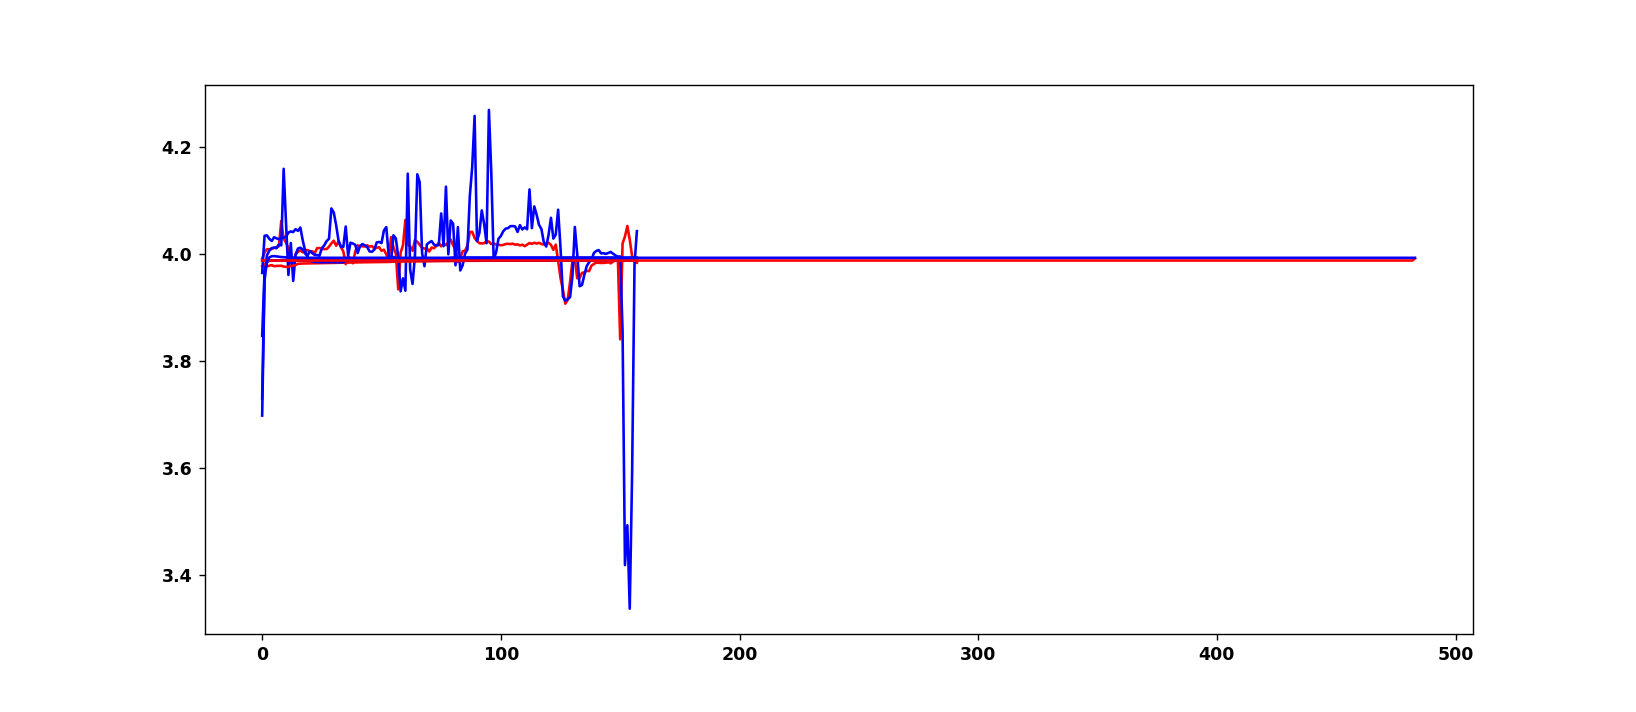

C:\Users\s.kaiser\Experiments\MuleCarData\split_models_result\vanila_lstm\3_1\model.h5
158 5 3
MSE:  0.0003756378621625324
RMSE:  0.019381379263678125
MAE:  0.010790226854251924
MAPE:  0.002709513428394183
C:\Users\s.kaiser\Experiments\MuleCarData\split_models_result\vanila_lstm\3_2\model.h5
158 5 3
MSE:  0.0004242693779813844
RMSE:  0.020597800318999705
MAE:  0.0018161806927451916
MAPE:  0.0004553818978124409


In [111]:
%matplotlib notebook
# print(len(li_ts))
# len(li_ts[3].li_horizontal_divided_ts_obj[0])
# len(li_ts[3].li_horizontal_inc_ts_obj[2].df)

# print(li_ts[3].li_horizontal_inc_ts_obj[2].model_name)
# print(li_ts[3].li_horizontal_inc_ts_obj[2].ts_analysis.test_X)
# print(li_ts[3].li_horizontal_inc_ts_obj[2].ts_analysis.path)
# plot_predictions(model, np_input, num_forecast, input_window, freeze=False)


for i in range(3):
    # vanilla lstm models
    # model_path = li_ts[3].li_horizontal_divided_ts_obj[i].ts_analysis.path
    model_path = os.path.join(cwd, 'split_models_result', 'vanila_lstm',  li_ts[3].li_horizontal_divided_ts_obj[i].id, 'model.h5')
    print(model_path)
    X = li_ts[3].li_horizontal_divided_ts_obj[i].ts_analysis.test_X
    y = li_ts[3].li_horizontal_divided_ts_obj[i].ts_analysis.test_y
    print(X.shape[0], X.shape[1], X.shape[2])
    li_actual, li_pred = plot_predictions(model_path, X, y, 0, X.shape[0])
    
    plt.plot(range(X.shape[0]), li_actual, c='red')
    plt.plot(range(X.shape[0]), li_pred, c='blue')
# x = np.arange(np_test_forecast.shape[0])
# custom_plot.plot_multi_line(("Stacked LSTM with droput: forecast on unseen data (without normalization)", li_ts[0].li_horizontal_divided_ts_obj[0].ts_analysis.path, "Voltage (V)"), (x, 'Time (sec)'), (li_ts[0].li_horizontal_divided_ts_obj[0].ts_analysis.test_y, "Actual"), (np_test_forecast, "Forecast"))
#         x = np.arange(np_test_forecast.shape[0])
#         custom_plot.plot_multi_line(("Vanilla LSTM forecast for split", li_ts[i].li_horizontal_divided_ts_obj[j].ts_analysis.path, "Voltage (V)"), (x, 'Time (sec)'), (li_ts[i].li_horizontal_divided_ts_obj[j].ts_analysis.test_y, "Actual"), (np_test_forecast, "Forecast"))


plt.show()

8
8
C:\Users\s.kaiser\Experiments\MuleCarData\inc_models_result\vanila_lstm\3_1\model.h5
321 5 3
MSE:  0.0019826845582473587
RMSE:  0.044527346184646564
MAE:  0.03972185908760238
MAPE:  0.009980731386464011
321
316


<IPython.core.display.Javascript object>


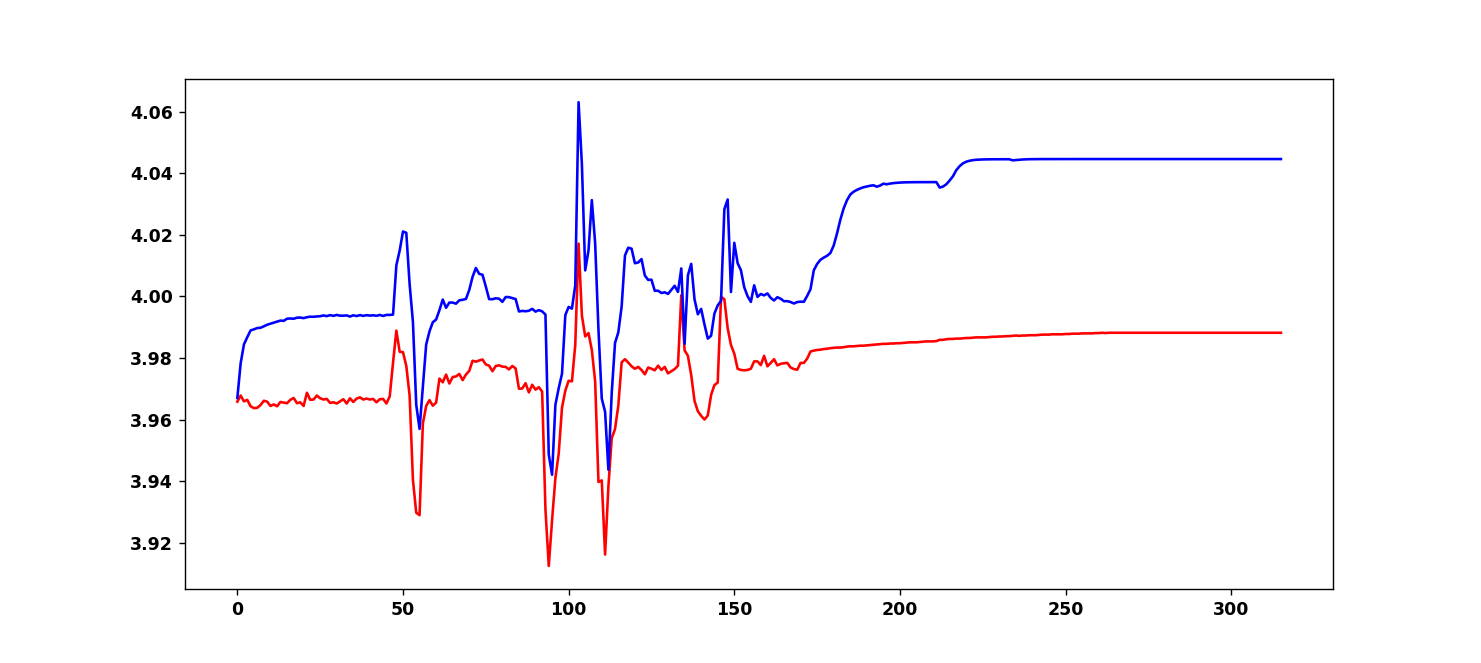

In [124]:
%matplotlib notebook
print(len(li_ts))
print(len(li_drive_cycles))
model_path = os.path.join(cwd, 'inc_models_result', 'vanila_lstm',  li_ts[3].li_horizontal_inc_ts_obj[1].id, 'model.h5')
print(model_path)
X = li_ts[3].li_horizontal_inc_ts_obj[1].ts_analysis.test_X
y = li_ts[3].li_horizontal_inc_ts_obj[1].ts_analysis.test_y
print(X.shape[0], X.shape[1], X.shape[2])
li_actual, li_pred = plot_predictions(model_path, X, y, 0, X.shape[0])

li_1 = li_actual[5:]
li_2 = li_pred[5:]
print(len(li_actual))
print(len(li_1))
x_vals = range(X.shape[0]- 5)
plt.plot(x_vals, li_1, c='red')
plt.plot(x_vals, li_2, c='blue')
plt.show()

<IPython.core.display.Javascript object>


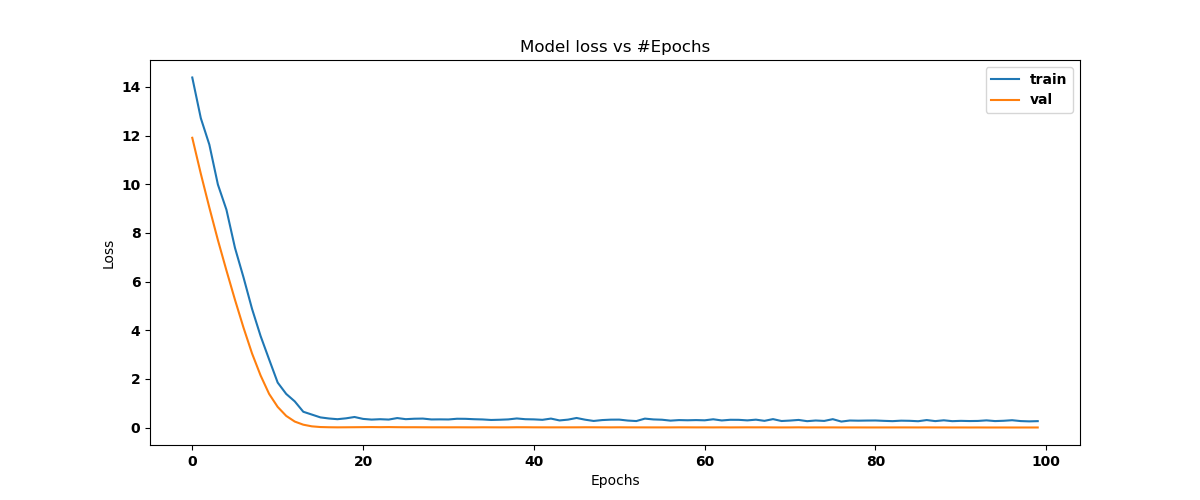

In [13]:
%matplotlib notebook
# plot loss
li_ts[0].li_horizontal_divided_ts_obj[0].plot_loss()

In [30]:
# Save the object
# sample usage
print(type(li_ts[0]))
save_object(li_ts[0], 'ts_analysed_test.pkl')

<class '__main__.TimeSeries'>


PicklingError: Can't pickle <class '__main__.TimeSeries'>: it's not the same object as __main__.TimeSeries

In [224]:
# predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def pred_rmse(model, X, y, start=0, end=1000):
    yhat = model.predict(X)    #shape = (n, 1) where n= X.shape[0] eg number of total data points
    yhat = yhat.flatten()
    df = pd.DataFrame(data={'Predictions':yhat, 'Actuals':y})
    df_temp = pd.DataFrame()
    df_temp['counter'] = range(len(y))   # x axis for plot
    custom_plot.plot_dual_axis((df_temp['counter'], "Time"), (df['Predictions'][start:end], "Predicted voltage"), (df['Actuals'], "Actual voltage"))

    rmse = mean_squared_error(y, yhat, squared=False)
    mse = mean_squared_error(y, yhat)
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("MAE: ", mae)
    print("MAPE: ", mape)
    return df_temp, mse


In [57]:
# Forecasting
# Apply rolling to foerrecast, the idea here: https://tsfresh.readthedocs.io/en/latest/text/forecasting.html
# Take a single data point and predict for that point, replace next actual data point with the predicted value, and move forward

# As prediction has to be done for each element, take the first data point
# np_input[0].reshape(np_input, (np_input[0].shape[0], 1))

def get_forecast_list(model, np_input, num_forecast, input_window, freeze=False):
    
#     from keras.models import load_model
#     model_LSTM_mutivariate = load_model(model_path)
    model_LSTM_mutivariate = model
    
    if (np_input.shape[0] < num_forecast):
        num_forecast = np_input.shape[0]

    NUM_INPUT_VARS = np_input.shape[2]
    np_input_copy = np.empty((num_forecast, input_window, NUM_INPUT_VARS), float)
    
    for i in range(num_forecast):
        np_input_copy[i] = np_input[i]      # fill with actual values

    li_predicted = []
    # predict and append
    for i in range(num_forecast):
        pred_ID = i + input_window    # nth prediction
        # single_input empty array is necessary because LSTM prediction takes input in (num_datapoints, input_window, num_variables) format 
        single_input = np.empty((1, input_window, NUM_INPUT_VARS), float)

        # whereas np_input[0] is in (input_window, num_variables) format
        single_input[0] = np_input[i]
    #     single_input_last_index = single_input.shape[1] - 1      # index where voltage needs to be replaced with predictions
    #     print('single_input_last_index: ', single_input_last_index)
        if(len(li_predicted) > 0):
            # print('li_predicted: ', li_predicted)
            for j in range(1, len(li_predicted)+1):
                if(j <= input_window):           # max input_window values to replace
                    _, single_input[0][-j][0] = li_predicted[-j]  # replace from last to first

        predictions = model_LSTM_mutivariate.predict(single_input).flatten()    # flatten returns 1D array
        li_predicted.append((pred_ID, predictions[0]))   # tuple of (id, predicted_value)

    li_rolling_predictoins = []
    for time_id,predict_val in li_predicted:
        li_rolling_predictoins.append(predict_val)

    # Current freezing
    if(freeze):
        FREEZE_DURATION = 15*60    # how many seconds we want to freeze (ex 15 minutes)
        # num_input_samples = np_input.shape[0]
        freeze_start_index = num_forecast - FREEZE_DURATION
        for i in range(freeze_start_index, num_forecast):
            for j in range(input_window):
                np_input_copy[i][j][1] = 0       # asisgn current = 0
        return np_input_copy, li_rolling_predictoins
    else:
        return li_rolling_predictoins


### model.evaluate vs model.predict
ref: https://stackoverflow.com/questions/44476706/what-is-the-difference-between-keras-model-evaluate-and-model-predict#:~:text=The%20model.,metric%20value%20as%20the%20output.

The model.evaluate function predicts the output for the given input and then computes the metrics function specified in the model.compile and based on y_true and y_pred and returns the computed metric value as the output.

The model.predict just returns back the y_pred

So if you use model.predict and then compute the metrics yourself, the computed metric value should turn out to be the same as model.evaluate

For example, one would use model.predict instead of model.evaluate in evaluating an RNN/ LSTM based models where the output needs to be fed as input in next time step



In [58]:
model = load_model(li_ts[0].li_horizontal_divided_ts_obj[0].model__path_name)

trainScore = model.evaluate(li_ts[0].li_horizontal_divided_ts_obj[0].ts_analysis.train_X, li_ts[0].li_horizontal_divided_ts_obj[0].ts_analysis.train_y, batch_size=1, verbose=0)
print('Train Score (MAE): [loss, accuracy] = ', trainScore)
testScore = model.evaluate(li_ts[0].li_horizontal_divided_ts_obj[0].ts_analysis.test_X, li_ts[0].li_horizontal_divided_ts_obj[0].ts_analysis.test_y, batch_size=1, verbose=0)
print('Test Score (MAE): [loss, accuracy] = ', testScore)


# li_test_forecast = get_forecast_list(X_test, 900)
# np_test_forecast = np.array(li_test_forecast)

NameError: name 'load_model' is not defined

In [ ]:
for i in range(len(li_ts)):
    for j in range(len(li_ts[i].li_horizontal_divided_ts_obj)):            # for each split of the cycle
        dir_path = os.path.join(cwd, 'inc_models_result', 'vanila_lstm',  li_ts[i].li_horizontal_divided_ts_obj[j].id)
        model = load_object(dir_path, model.h5)
        li_test_forecast = get_forecast_list(model, li_ts[i].li_horizontal_divided_ts_obj[j].ts_analysis.test_X, 200, 5)
        np_test_forecast = np.array(li_test_forecast)
        x = np.arange(np_test_forecast.shape[0])
        custom_plot.plot_multi_line(("Vanilla LSTM forecast for split", li_ts[i].li_horizontal_divided_ts_obj[j].ts_analysis.path, "Voltage (V)"), (x, 'Time (sec)'), (li_ts[i].li_horizontal_divided_ts_obj[j].ts_analysis.test_y, "Actual"), (np_test_forecast, "Forecast"))
    break

In [15]:
# forecast
# li_ts[0].li_horizontal_divided_ts_obj[0].model__path_name
# print(li_ts[0].li_horizontal_divided_ts_obj[0].ts_analysis.test_X.shape[0])
li_test_forecast = get_forecast_list(li_ts[0].li_horizontal_divided_ts_obj[0].model__path_name, li_ts[0].li_horizontal_divided_ts_obj[0].ts_analysis.test_X, 200, 5)
np_test_forecast = np.array(li_test_forecast)


In [18]:
# print(np_test_forecast, np_test_forecast.shape)
# print(li_ts[0].li_horizontal_divided_ts_obj[0].ts_analysis.test_y)

[3.6899252 3.9151902 3.9999175 4.0425196 4.0679507 4.082876  4.0947337
 4.102696  4.106628  4.106299  4.100703  4.096093  4.0911746 4.0925236
 4.0846605 4.0782256 4.0718293 4.066355  4.0654163 4.060762  4.0655823
 4.070069  4.0814366 4.0883613 4.093531  4.096103  4.0982475 4.100202
 4.1012726 4.1021523 4.1027226 4.1023145 4.101765  4.101844  4.099971
 4.09993   4.0959077 4.093319  4.0945926 4.0958242 4.097175  4.0970488
 4.0995765 4.0983086 4.0991387 4.0945888 4.1129613 4.073702  4.0304155
 4.046932  4.027458  4.0697517 4.0818744 4.0817747 4.083364  4.0963235
 4.097261  4.0978484 4.108339  4.109942  4.1144876 4.112292  4.1116076
 4.111835  4.1100626 4.099891  4.093343  4.094458  4.095848  4.095673
 4.0947456 4.092934  4.0956984 4.0895257 4.0911503 4.091923  4.0938735
 4.098674  4.1005735 4.1002765 4.0980206 4.0966325 4.0961    4.095196
 4.0954013 4.0953746 4.0934668 4.091512  3.914217  4.013043  4.082706
 4.1073728 4.1629357 4.1632495 4.130719 ] (95,)
[4.0731 4.0704 4.0736 4.0693 4.068

<IPython.core.display.Javascript object>


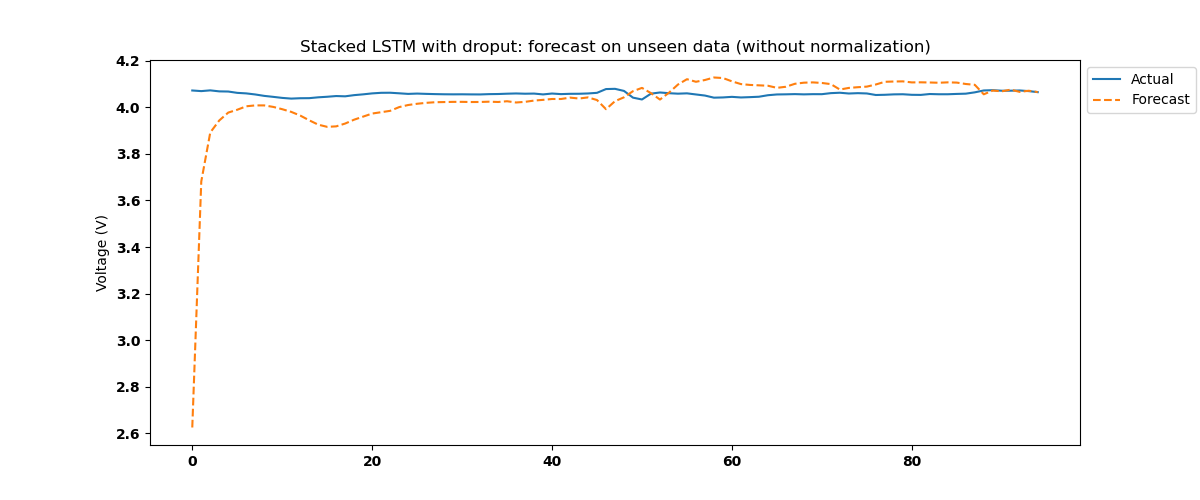

In [16]:
%matplotlib notebook
x = np.arange(np_test_forecast.shape[0])
custom_plot.plot_multi_line(("Stacked LSTM with droput: forecast on unseen data (without normalization)", li_ts[0].li_horizontal_divided_ts_obj[0].ts_analysis.path, "Voltage (V)"), (x, 'Time (sec)'), (li_ts[0].li_horizontal_divided_ts_obj[0].ts_analysis.test_y, "Actual"), (np_test_forecast, "Forecast"))